## Constants
Modify these constants to change the behavior of the program. 
* TRACK_LENGTH: The maximum length of track to allow in the output dataset.

* ALL_FEATURES: These are all the features that we've aggregated throughout the project (this doesn't change).
* USED_FEATURES: These are the features that are to be used to train the classifier (this can change).

* DATA_READ_FILE: The (raw) data file to read in and process.
* DATA_READ_PATH: Where to read the data from.

* DATA_WRITE_FILE: The name of the file to write the processed data to.
* DATA_WRITE_PATH: Where to write the processed data to.
* WRITE_DATA: Set to True if you wish to write the processed data to a file.

* MODEL_READ_PATH: Where to read a model from (if evaluating an existing model.
* READ_MODEL: Set to True if you wish to read a model from a file.

* MODEL_WRITE_FILE: The name of the file to write the model to.
* MODEL_WRITE_PATH: Where to write the new model to.
* WRITE_MODEL: Set to True if you wish to write the model to a new file.

* SAVE_COMBINED_SIMULATED: Set to True if you wish to save the combined simulated data to a new file.

In [212]:
TRACK_LENGTH = 20

ALL_FEATURES = ['Average Speed', 'Stan. Dev. Speed', 'Average Heading', 'Stan. Dev. Heading', 
            'Average Curvature', 'Maneuverability', 'M1 Range', 'M1 AZ', 'M1 EL', 'M1 Speed', 
            'M1 Heading', 'M2 Range', 'M2 AZ', 'M2 EL', 'M2 Speed', 'M2 Heading']
USED_FEATURES = ['Average Speed', 'Stan. Dev. Speed', 'Average Heading', 'Stan. Dev. Heading', 
            'Average Curvature', 'Maneuverability', 'M1 Range', 'M1 AZ', 'M1 EL', 'M1 Speed', 
            'M1 Heading', 'M2 Range', 'M2 AZ', 'M2 EL', 'M2 Speed', 'M2 Heading']

DATA_READ_FILES = {"Bird": "Marked_Radar_Data_Birds.csv",
                   "Drone": "Marked_Radar_Data_Drones.csv"}
DATA_READ_PATHS = {name: f"../data/processed/crane/{file}" for name, file in DATA_READ_FILES.items()}

DATA_WRITE_FILE = f"bird_drone_{TRACK_LENGTH}"
DATA_WRITE_PATH = f"../data/processed/crane/{DATA_WRITE_FILE}.csv"
WRITE_DATA = False

MODEL_READ_PATH = ""
READ_MODEL = False

MODEL_WRITE_FILE = DATA_WRITE_FILE
MODEL_WRITE_PATH = f"../models/{MODEL_WRITE_FILE}.sav"
WRITE_MODEL = False

SAVE_COMBINED_SIMULATED = False

# MODEL TRAINING
CLASS_WEIGHTS = {0: 1, 1: 4}

## Imports

In [213]:
import glob
import pickle
import uuid

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn import metrics, tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

## Helper functions

In [214]:
def chunk_group(group):
    if len(group) > TRACK_LENGTH:
        count = 0
        
        for idx, row in group.iterrows():
            if count % TRACK_LENGTH == 0:
                new_id = str(uuid.uuid4())
        
            group.at[idx, "UUID"] = new_id
            count += 1
            
    return group

In [215]:
def combine_simulated_data(data_read = "../data/raw/simulated/simulatedDroneData*.csv", 
                           data_write="../data/raw/simulated/combinedSimulatedData.csv"):
    files = glob.glob(data_read)
    combined_df = pd.DataFrame()
    
    for file in files:
        df = pd.read_csv(file)
        df["UUID"] = "None"
    
        identifier = str(uuid.uuid4())
        for idx, row in df.iterrows():
            if idx % 20 == 0:
                identifier = str(uuid.uuid4())
            df.at[idx, "UUID"] = identifier
    
        # print(f"{len(df)}: {len(df["UUID"].unique())}")
        combined_df = pd.concat([combined_df, df])
    
    grouped_df = combined_df.groupby("UUID")
    print(f"number of plots: {len(combined_df)}")
    print(f"number of UUIDs: {len(grouped_df)}")
    
    size = grouped_df.size()
    print(f"\tmax track size: {max(size)}")
    print(f"\tmin track size: {min(size)}")
    print(f"\tmean track size: {size.mean()}")
    
    if SAVE_COMBINED_SIMULATED:
        combined_df.to_csv(data_write, index=False)

In [216]:
def display_track_info(name_df_pairs):
    for name, df in name_df_pairs:
        print(f"* ================================ {name} ================================ *")
        grouped_df = df.groupby("UUID")
        print(f"number of plots: {len(df)}")
        print(f"number of UUIDs: {len(grouped_df)}")
        
        size = grouped_df.size()
        print(f"\tmax track size: {max(size)}")
        print(f"\tmin track size: {min(size)}")
        print(f"\tmean track size: {size.mean()}")

## Read in the data

In [217]:
bird_df = pd.read_csv(DATA_READ_PATHS["Bird"])
drone_df = pd.read_csv(DATA_READ_PATHS["Drone"])

## Analyze tracks in each file

In [218]:
name_df_pairs = [("Bird", bird_df), ("Drone", drone_df)]
display_track_info(name_df_pairs)

* ================================ Bird ================================ *
number of plots: 31211
number of UUIDs: 133
	max track size: 1622
	min track size: 20
	mean track size: 234.66917293233084
* ================================ Drone ================================ *
number of plots: 11403
number of UUIDs: 9
	max track size: 2753
	min track size: 530
	mean track size: 1267.0


## Break the tracks down

In [219]:
bird_df = bird_df.groupby("UUID").apply(chunk_group).reset_index(drop=True)
drone_df = drone_df.groupby("UUID").apply(chunk_group).reset_index(drop=True)

name_df_pairs = [("Bird", bird_df), ("Drone", drone_df)]
display_track_info(name_df_pairs)

* ================================ Bird ================================ *
number of plots: 31211
number of UUIDs: 1624
	max track size: 20
	min track size: 1
	mean track size: 19.2185960591133
* ================================ Drone ================================ *
number of plots: 11403
number of UUIDs: 574
	max track size: 20
	min track size: 1
	mean track size: 19.865853658536587


## Combine bird and drone data

In [220]:
bird_df["Label"] = 0
drone_df["Label"] = 1

if all(bird_df.columns == drone_df.columns):
    print("Bird columns match drone columns. Combining data.")
    X = pd.concat([bird_df, drone_df])
else:
    print("Bird columns do NOT match drone columns. Need to investigate.")
    print(bird_df.columns)
    print(drone_df.columns)

Bird columns match drone columns. Combining data.


## Save data to CSV

In [221]:
if WRITE_DATA:
    X.to_csv(DATA_WRITE_PATH)

## Functions for calculating feature vectors

In [222]:
def calculate_avg_speed(input_df):
    return input_df["Speed"].mean()

def calculate_std_speed(input_df):
    return input_df["Speed"].std(ddof=0)

def calculate_heading(input_df):
    delta_x = input_df["Position (lat)"] - input_df["Position (lat)"].shift(-1)
    delta_y = input_df["Position (lon)"] - input_df["Position (lon)"].shift(-1)   
    return np.arctan2(delta_y, delta_x)

def calculate_avg_heading(input_df):
    heading = calculate_heading(input_df)
    return np.mean(heading)

def calculate_std_heading(input_df):
    heading = calculate_heading(input_df)
    return np.std(heading)

# def calculate_osc_factor(input_df):
#     heading = calculate_heading(input_df)
#     theta = heading.shift(1) - heading
# 
#     om = theta.copy(deep=True)
#     om[theta > 0.5] = 1
#     om[theta < -0.5] = -1
#     om[abs(theta) <= 0.5] = 0
# 
#     w = om.copy(deep=True)
#     osc_number = 1
#     for j in range(1, om.shape[0]-1):
#         w[j] = osc_number    
        
def calculate_average_curvature(group):
    a = np.sqrt((group["Position (lat)"] - group["Position (lat)"].shift(-1))**2 + 
                (group["Position (lon)"] - group["Position (lon)"].shift(-1))**2 + 
                (group["Position (alt MSL)"] - group["Position (alt MSL)"].shift(-1))**2)
    
    b = np.sqrt((group["Position (lat)"] - group["Position (lat)"].shift(-2))**2 + 
                (group["Position (lon)"] - group["Position (lon)"].shift(-2))**2 + 
                (group["Position (alt MSL)"] - group["Position (alt MSL)"].shift(-2))**2)
    
    c = np.sqrt((group["Position (lat)"].shift(-1) - group["Position (lat)"].shift(-2))**2 + 
                (group["Position (lon)"].shift(-1) - group["Position (lon)"].shift(-2))**2 + 
                (group["Position (alt MSL)"].shift(-1) - group["Position (alt MSL)"].shift(-2))**2)
    
    with np.errstate(invalid="ignore"): 
        # arccos throwing invalid value error on what seems to be valid inputs
        curvature = np.arccos((a[:-2]**2 - b[:-2]**2 - c[:-2]**2)/(2 * b[:-2] * c[:-2]))
        
    return curvature.mean()

def calculate_m1(df, field):
    diff = (df[field].shift(-1) - df[field])[:-1]
    q = np.sum(diff) / len(df)
    m1 = np.sum((diff - q)**2)/len(df)
    return m1
    
def calculate_m2(df,field):
    diff = (df[field].shift(-1) - df[field])[:-1]
    q = np.sum(diff) / len(df)
    m1 = np.sum((diff - q)**2) / len(df)
    c = np.sum(np.abs(diff)) / len(df)
    if c == 0:
        return 0
    m2 = m1/c
    return m2

def get_feature_vectors(df):
    calc_dict = dict()
    for feature in ALL_FEATURES:
        calc_dict[feature] = []
        
    for uuid, group in df.groupby("UUID"):
        avg_speed = calculate_avg_speed(group)
        std_heading = calculate_std_heading(group)
        
        calc_dict['Average Speed'].append(avg_speed)
        calc_dict['Stan. Dev. Speed'].append(calculate_std_speed(group))
        calc_dict['Average Heading'].append(calculate_avg_heading(group))
        calc_dict['Stan. Dev. Heading'].append(std_heading)
        calc_dict['Average Curvature'].append(calculate_average_curvature(group))
        calc_dict['Maneuverability'].append(avg_speed / std_heading if std_heading > 0 else avg_speed / 1e-9)
        
        group = group.assign(Heading=calculate_heading(group))
        
        for field in ['Speed', 'Range', 'AZ', 'EL', 'Heading']:
            calc_dict['M1 ' + field].append(calculate_m1(group, field))
            calc_dict['M2 ' + field].append(calculate_m2(group, field))

    return pd.DataFrame(calc_dict)[USED_FEATURES]

## Form feature vector DataFrame

In [223]:
X_grouped = X.groupby("UUID")

# X_new and y_new are what we will use to train and evaluate the models
X_new = get_feature_vectors(X)
y_new = X_grouped["Label"].first()

In [224]:
X_new.fillna(X_new.mean(), inplace=True)
# X_new.replace([np.inf], 99999, inplace=True)
# X_new.replace([-np.inf], -99999, inplace=True)

scaler = MinMaxScaler()
X_new = scaler.fit_transform(X_new)

In [225]:
val_counts = y_new.value_counts()
bird_df_tracks = len(bird_df.groupby("UUID"))
drone_df_tracks = len(drone_df.groupby("UUID"))

check1 = val_counts[0] == bird_df_tracks
print(f"\nBird labels in y_new == number of bird tracks ? {check1}")

check2 = val_counts[1] == drone_df_tracks
print(f"Drone labels in y_new == number of drone tracks ? {check2}")

check3 = len(X_new) == len(y_new)
print(f"Length of X_new == length of y_new ? {check3}")


Bird labels in y_new == number of bird tracks ? True
Drone labels in y_new == number of drone tracks ? True
Length of X_new == length of y_new ? True


### Train Model

In [230]:
# split the data into distinct training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=0.2)

# read model from file, if desired
if READ_MODEL:
    model = pickle.load(open(MODEL_READ_PATH, 'rb'))

# otherwise, train the model
else:
    # class weights bias the model toward one outcome over another
    model = RandomForestClassifier(class_weight=CLASS_WEIGHTS)
    model.fit(X_train, y_train)

## Evaluate the model

In [231]:
# use the trained model to generate predictions
model_pred = model.predict(X_test)

# get the confidence levels of each model
model_confidence_pair = model.predict_proba(X_test)

In [232]:
accuracy = metrics.accuracy_score(y_test, model_pred)
print(f'accuracy = {100 * accuracy}')

accuracy = metrics.f1_score(y_test, model_pred)
print(f'f1 score = {100 * accuracy}')

model_confidence = [max(pair) for pair in model_confidence_pair]
avg_model_confidence = np.mean(model_confidence)
med_model_confidence = np.median(model_confidence)

print(f'\naverage confidence level: {avg_model_confidence}')
print(f'median confidence level: {med_model_confidence}')

accuracy = 94.0909090909091
f1 score = 88.79310344827587

average confidence level: 0.8970000000000001
median confidence level: 0.96


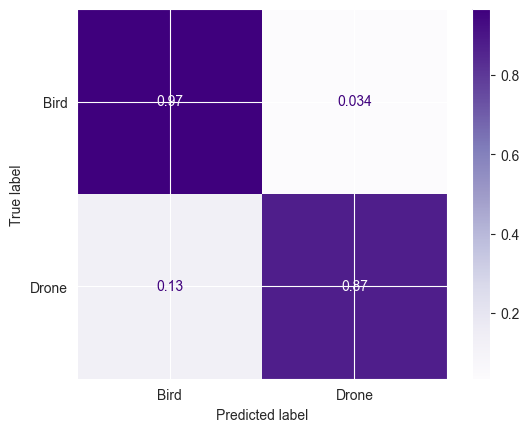

In [233]:
confusion_matrix = metrics.confusion_matrix(y_test, model_pred, normalize='true')
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, 
                                            display_labels = ["Bird", "Drone"])
cm_display.plot(cmap=plt.cm.Purples)
plt.show()

## Visualize Decision Trees

number of trees in rf: 100


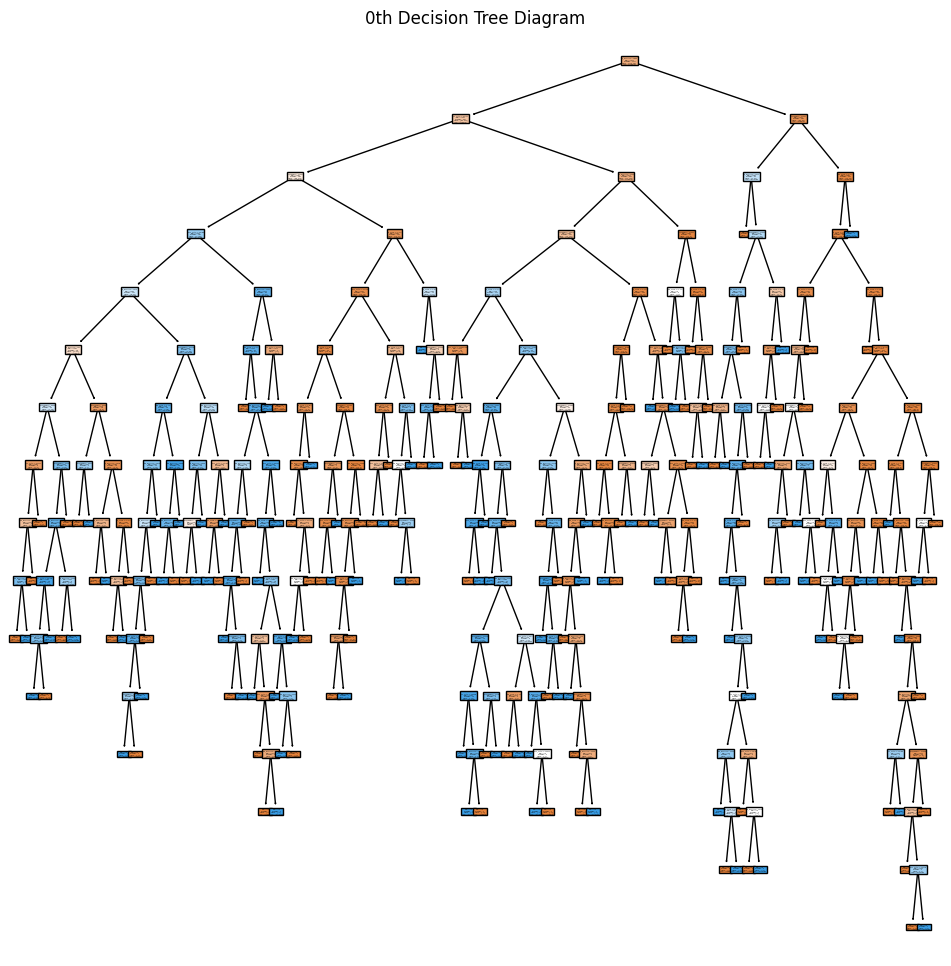

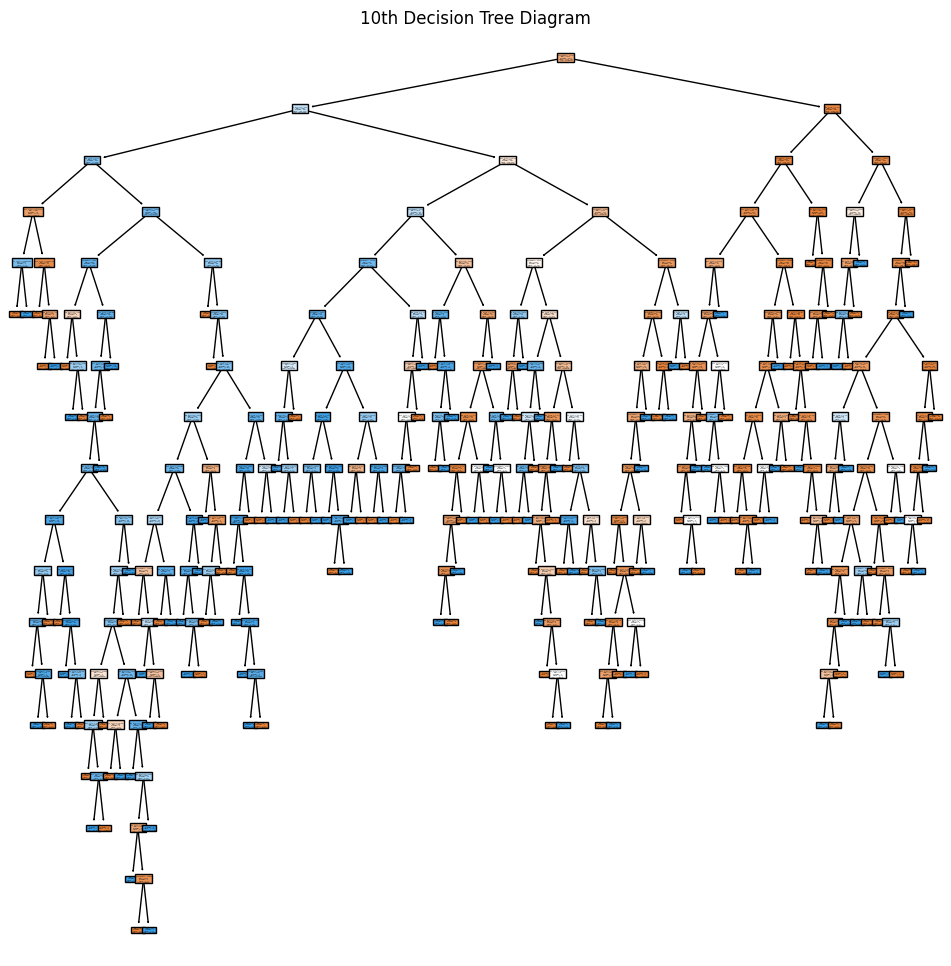

In [32]:
print(f'number of trees in rf: {len(model.estimators_)}')

for i in [0, 10]:
    plt.figure(figsize=(12, 12))
    tree.plot_tree(model.estimators_[i],
                feature_names = X_new.columns, 
                class_names=['Biological', 'Man-made'],
                filled = True)
    plt.title(f"{i}th Decision Tree Diagram")
    plt.show()

## Determine Feature Importances

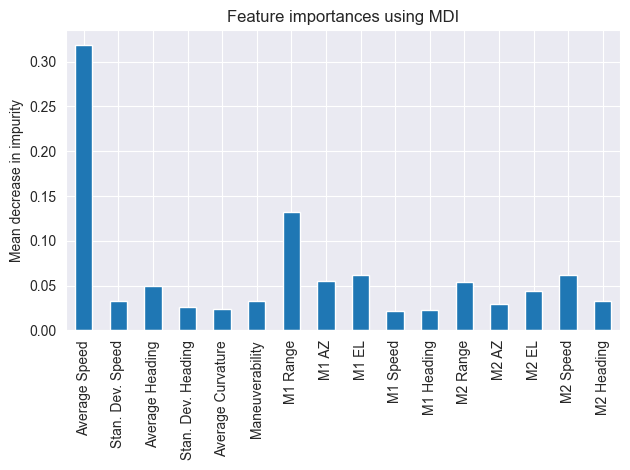

In [19]:
importance = model.feature_importances_

forest_importance = pd.Series(importance, index=list(X_new.columns))

fig, ax = plt.subplots()
forest_importance.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

## Save Model

In [234]:
if WRITE_MODEL:
    pickle.dump(model, open(MODEL_WRITE_PATH, 'wb'))

In [241]:
test_df = pd.read_csv("../data/raw/crane/ecco.csv")
lats_and_lons = test_df.groupby("UUID")[["Position (lat)", "Position (lon)"]].mean()
sorted_lats_lons = lats_and_lons.sort_values(by=["Position (lat)", "Position (lon)"])
middle = sorted_lats_lons.iloc[40:50]
print(middle)

                                      Position (lat)  Position (lon)
UUID                                                                
a420ee1f-9743-41c8-800a-b87b2b5abcaf       38.905112      -86.869002
41f77523-3262-4a23-b8bf-bff64f6326b7       38.905123      -86.827195
b79d99fc-d34c-40e8-9be9-3b9ede629f7b       38.905633      -86.869756
bb6cb0b7-0be0-42bf-a912-afc9f87b2d09       38.906032      -86.825302
a9a4f93e-fcad-4635-bfc1-ea18d77440ba       38.906543      -86.825095
cf1e5640-883a-4bb0-8553-b9d05c12ef56       38.906732      -86.826494
e3671326-7206-4e32-8408-7e7a823acc5b       38.906734      -86.826478
7fdae774-f45f-4725-a2de-a5a89e782eee       38.907519      -86.826716
3f96526e-775d-4cc5-9095-72b7afba4172       38.907743      -86.826516
115ebb34-1e47-40bd-adbe-23468341d4e9       38.907778      -86.861855


/var/folders/sx/0gyr6z3573gdm1mnzzc8vw980000gn/T/ipykernel_3408/1112033084.py:1: DtypeWarning: Columns (0,1,2,3,4,5,6,8,9,11,12,26,34,35,42,43) have mixed types. Specify dtype option on import or set low_memory=False.
  test_df = pd.read_csv("../data/raw/crane/ecco.csv")
